In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import importlib
import utils_threshold
import utils_markov 

# Markov Model

In [2]:
datain = pd.read_csv("datasets/csv1.csv")
datain['Date'] = pd.to_datetime(datain['Date'])
datalist = datain['Value'].to_numpy()
dsize = datalist.size
dsize

551

In [142]:
importlib.reload(utils_threshold)

thresholds = [10, 12.5, 20, 23]
order = 1
observed_states, _ = utils_threshold.discretize_thresholds(datalist, thresholds)
markov = utils_threshold.avg_markov_from_data(10000, datalist, thresholds, noise_mean=0, noise_variance=0)
markov

array([[0.71428571, 0.28571429, 0.        , 0.        , 0.        ],
       [0.03125   , 0.90625   , 0.0625    , 0.        , 0.        ],
       [0.        , 0.00995025, 0.97014925, 0.0199005 , 0.        ],
       [0.        , 0.        , 0.14285714, 0.80952381, 0.04761905],
       [0.        , 0.        , 0.        , 0.21428571, 0.78571429]])

# Predict one point ahead from observed data & compare

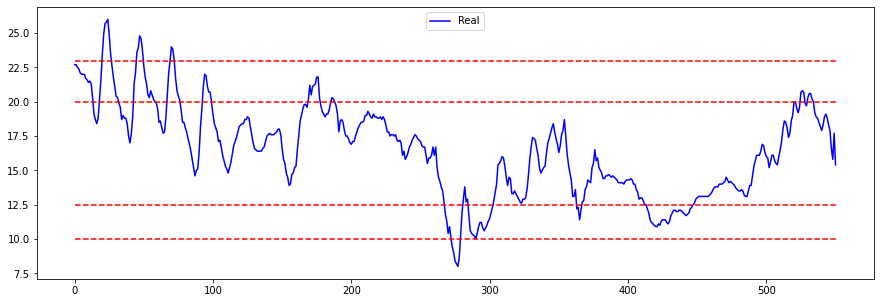

In [4]:
x_axis = np.arange(dsize)

plt.figure(figsize=(15,5))
plt.plot(x_axis, datalist, color="b", label="Real")

# plot threshold lines
for thres in thresholds:
    plt.plot(x_axis, thres*np.ones(len(x_axis)), color="r", linestyle='dashed')

plt.legend(loc=9)

# Random walks on Markov Graph

show one random walk in the future + its log-probability (not pure probability to avoid underflow)

In [141]:
importlib.reload(utils_markov)

utils_markov.random_walk_weighted(5, markov, observed_states)

{'log_prob': -0.15152674747600603,
 'path': array([2, 2, 2, 2, 2, 2], dtype=int64)}